In [1]:
# Imports
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split

import torch
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
from torch import nn

In [2]:
data = pd.read_csv("data/train.csv")

In [3]:
# Read data
def read_img(file_name):
    data = pd.read_csv("data/" + file_name)
    labels = data["label"].to_numpy()
    imgs = (data.iloc[:, 1:].to_numpy()).reshape((len(labels),28,28)).astype("float32")
    return imgs, labels

In [4]:
# Split
imgs, labels = read_img("train.csv")
imgtrain, imgtest, labeltrain, labeltest = train_test_split(imgs, labels, test_size=.3)

In [5]:
imgtrain.shape

(29400, 28, 28)

In [6]:
class DigitDataset(Dataset):
    def __init__(self, images, labels):
        self.images = torch.tensor(images)/255.0
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.images[idx], self.labels[idx]

In [7]:
train_ds = DigitDataset(imgtrain, labeltrain)
test_ds = DigitDataset(imgtest, labeltest)

In [8]:
from torch.utils.data import DataLoader

train_dl = DataLoader(train_ds, batch_size=16, shuffle=True)
test_dl = DataLoader(test_ds, batch_size=16, shuffle=True)

Feature batch shape: torch.Size([16, 28, 28])
Labels batch shape: torch.Size([16])


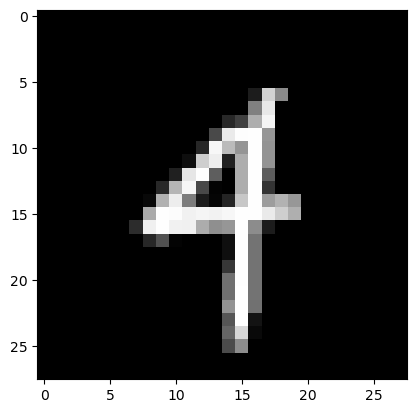

Label: 4


In [9]:
# Display image and label.
train_features, train_labels = next(iter(train_dl))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

In [10]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


In [26]:
import torch.nn as nn
import torch.nn.functional as F

# PyTorch models inherit from torch.nn.Module
class GarmentClassifier(nn.Module):
    def __init__(self):
        super(GarmentClassifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


model = GarmentClassifier()

In [16]:
loss_fn = torch.nn.CrossEntropyLoss()

# NB: Loss functions expect data in batches, so we're creating batches of 4
# Represents the model's confidence in each of the 10 classes for a given input
dummy_outputs = torch.rand(4, 10)
# Represents the correct class among the 10 being tested
dummy_labels = torch.tensor([1, 5, 3, 7])

print(dummy_outputs)
print(dummy_labels)

loss = loss_fn(dummy_outputs, dummy_labels)
print('Total loss for this batch: {}'.format(loss.item()))

tensor([[0.8375, 0.3496, 0.8416, 0.8383, 0.8151, 0.6611, 0.2588, 0.4906, 0.0841,
         0.4280],
        [0.5365, 0.1846, 0.6242, 0.5890, 0.7302, 0.7894, 0.7416, 0.6153, 0.6752,
         0.2539],
        [0.8049, 0.0558, 0.1825, 0.7905, 0.5414, 0.3291, 0.7931, 0.6145, 0.5515,
         0.4741],
        [0.5601, 0.1639, 0.3292, 0.3713, 0.9581, 0.1627, 0.6591, 0.2093, 0.1553,
         0.9013]])
tensor([1, 5, 3, 7])
Total loss for this batch: 2.3227453231811523


In [29]:
# Optimizers specified in the torch.optim package
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

In [23]:
def train_one_epoch(epoch_index, tb_writer):
    running_loss = 0.
    last_loss = 0.

    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    for i, data in enumerate(train_dl):
        # Every data instance is an input + label pair
        inputs, labels = data

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        inputs = inputs.unsqueeze(1)
        outputs = model(inputs)

        # Compute the loss and its gradients
        loss = loss_fn(outputs, labels)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()
        if i % 1000 == 999:
            last_loss = running_loss / 1000 # loss per batch
            print('  batch {} loss: {}'.format(i + 1, last_loss))
            tb_x = epoch_index * len(train_dl) + i + 1
            tb_writer.add_scalar('Loss/train', last_loss, tb_x)
            running_loss = 0.

    return last_loss

In [32]:
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime

# Initializing in a separate cell so we can easily add more epochs to the same run
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter('runs/fashion_trainer_{}'.format(timestamp))
epoch_number = 0

EPOCHS = 5

best_vloss = 1_000_000.

for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch_number + 1))

    # Make sure gradient tracking is on, and do a pass over the data
    model.train(True)
    avg_loss = train_one_epoch(epoch_number, writer)


    running_vloss = 0.0
    # Set the model to evaluation mode, disabling dropout and using population
    # statistics for batch normalization.
    model.eval()

    # Disable gradient computation and reduce memory consumption.
    with torch.no_grad():
        for i, vdata in enumerate(test_dl):
            vinputs, vlabels = vdata
            vinputs = vinputs.unsqueeze(1)
            voutputs = model(vinputs)
            vloss = loss_fn(voutputs, vlabels)
            running_vloss += vloss

    avg_vloss = running_vloss / (i + 1)
    print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))

    # Log the running loss averaged per batch
    # for both training and validation
    writer.add_scalars('Training vs. Validation Loss',
                    { 'Training' : avg_loss, 'Validation' : avg_vloss },
                    epoch_number + 1)
    writer.flush()

    # Track best performance, and save the model's state
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss

    epoch_number += 1

EPOCH 1:
  batch 1000 loss: 0.045806445825890475
LOSS train 0.045806445825890475 valid 0.08106370270252228
EPOCH 2:
  batch 1000 loss: 0.03591700020433927
LOSS train 0.03591700020433927 valid 0.06827408075332642
EPOCH 3:
  batch 1000 loss: 0.029360756076033112
LOSS train 0.029360756076033112 valid 0.06507249176502228
EPOCH 4:
  batch 1000 loss: 0.02440488726655758
LOSS train 0.02440488726655758 valid 0.05394243448972702
EPOCH 5:
  batch 1000 loss: 0.025887012114303616
LOSS train 0.025887012114303616 valid 0.04978689178824425


In [51]:
class DigitNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv2dstack = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=(5,5)),
            nn.Tanh(),
            nn.MaxPool2d((2,2)),
            nn.Tanh(),
            nn.Conv2d(6, 16, (5,5), groups=2),
            nn.Tanh(),
            nn.MaxPool2d((2,2)),
            nn.Tanh()
        )
        self.flatten = nn.Flatten()
        self.t1 = nn.Tanh()
        self.linear = nn.LazyLinear(100)
        self.t2 = nn.Tanh()
        self.output = nn.Linear(100, 10)
        self.softmax = nn.LogSoftmax(dim=1)


    def forward(self, x):
        x = self.conv2dstack(x)
        x = self.flatten(x)
        x = self.t1(x)
        x = self.linear(x)
        x = self.t2(x)
        x = self.output(x)
        logits = self.softmax(x)
        return logits

In [52]:
dn = DigitNetwork()

c:\Users\MeetA\anaconda3\Lib\site-packages\torch\nn\modules\lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [53]:
train_features.unsqueeze(1).shape

torch.Size([16, 1, 28, 28])

In [68]:
pred = dn(train_features.unsqueeze(1))

In [79]:
torch.argmax(pred, dim=1)

tensor([4, 8, 5, 0, 5, 0, 7, 4, 0, 6, 4, 5, 5, 3, 7, 4])

In [80]:
train_labels

tensor([4, 8, 5, 0, 5, 0, 7, 4, 0, 6, 4, 5, 5, 3, 7, 4])

In [78]:
pred.size()

torch.Size([16, 10])

In [43]:
nn.functional.nll_loss(pred, train_labels, reduction="sum")

tensor(-260.8852, grad_fn=<NllLossBackward0>)

In [54]:
batch_size_train = 64
batch_size_test = 1000

In [55]:
def test(model, loader):
    """Test a network model on the test data.
    
    model: a `nn.Module` object representing the neural network to test
    loader: a `DataLoader` object containing the testing data, potentially in batches
    
    Returns a tuple (test_loss, accuracy), where test_loss is the average loss on the
    test data, and accuracy is the accuracy rate (out of 100%) of the predictions.
    """
    
    # Put the network in evaluation mode
    model.eval()
    
    test_loss = 0
    correct = 0
    
    # don't track gradients during this calculation
    with torch.no_grad():
        for data, target in loader:
            data = data.unsqueeze(1)
            output = model(data)
            
            # calculate the loss on this batch
            test_loss += nn.functional.nll_loss(output, target, reduction='sum').item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()

    # get the overall loss across all batches
    test_loss /= len(loader.dataset)
    accuracy = 100.0 * correct / len(loader.dataset)
    
    return test_loss, accuracy

In [56]:
def train(model, optimizer, train_loader, test_loader, n_epochs=3, log_interval=50, verbose=False):
    """Train a network model with a particular optimizer.
    
    model: a `nn.Module` object representing the neural network to train
    optimizer: a PyTorch optimizer, such as SGD
    train_loader: a `DataLoader` object containing the training data, potentially in batches
    test_loader: the same, but for the testing data
    n_epochs: number of epochs of training to run
    log_interval: after how many batches should record our progress?
    verbose: print the progress after each log_interval steps?
    
    Returns a tuple (train_losses, counter, test_losses). train_losses is a list of 
    losses after every log_interval training steps; train_counter is a list giving the number
    of training observations seen by the training process by each of those steps; test_losses
    gives the test-set loss before each epoch and after the final epoch; test_counter gives
    the number of training observations seen at each epoch.
    """
    
    # Storage
    train_losses = []
    test_losses = []
    train_counter = []
    test_counter = []
    
    samples_seen = 0
    
    for epoch in range(n_epochs):
        # test at the beginning of each epoch
        test_loss, _ = test(model, test_loader)
        test_losses.append(test_loss)
        test_counter.append(samples_seen)
        
        model.train() # put the network in training mode

        for batch_idx, (data, target) in enumerate(train_loader):
            data = data.unsqueeze(1)
            # Reset all gradients
            optimizer.zero_grad()
    
            # Obtain the model's predictions with the data
            predictions = model(data)
    
            # Get the loss, using the known Ys
            loss = nn.functional.nll_loss(predictions, target)
    
            # Calculate the gradients with backpropagation
            loss.backward()
    
            # Perform one gradient descent step
            optimizer.step()

            # Count how much data we've seen
            samples_seen += batch_size_train
            
            # Every log_interval steps, print out the progress
            if batch_idx % log_interval == 0:
                if verbose:
                    print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                        epoch + 1, batch_idx * len(data), len(train_loader.dataset),
                        100.0 * batch_idx / len(train_loader), loss.item()))
                
                train_losses.append(loss.item())
                train_counter.append(samples_seen)
                

    # test after the final epoch
    test_loss, _ = test(model, test_loader)
    test_losses.append(test_loss)
    test_counter.append(samples_seen)
                
    return train_losses, train_counter, test_losses, test_counter

In [57]:
optimizer2 = torch.optim.SGD(dn.parameters(), lr=0.01, momentum=0.5)

In [59]:
train_losses2, train_counter2, test_losses2, test_counter2 = train(
    dn, optimizer2, train_dl, test_dl, n_epochs=10)

In [62]:
test_losses2[-1]

0.047919649399414156

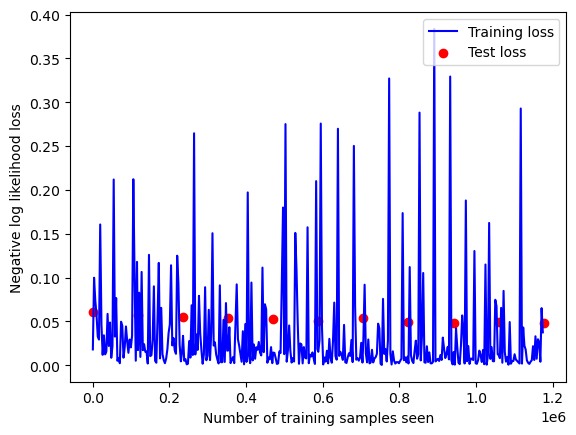

In [63]:
plt.plot(train_counter2, train_losses2, color="blue")
plt.scatter(test_counter2, test_losses2, color="red")
plt.legend(["Training loss", "Test loss"], loc="upper right")
plt.xlabel("Number of training samples seen")
plt.ylabel("Negative log likelihood loss");